In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyBioInfo.IO.File import GtfFile, GtfTranscriptBuilder, FastaFile

infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")

runs = ["20220719_K562R1", "20220719_K562R2", "20220719_K562R3", "20220719_K562R4", 
        "20220729_K562R1", "20220729_K562R2"]

# Isoform length

In [5]:
runs = ["20220719_K562R1", "20220719_K562R2", "20220719_K562R3", "20220719_K562R4", "20220729_K562R1", "20220729_K562R2"]
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[[run in runs for run in d["Run"]]]
d = d[d["UMIs"] >= 5000]
print(len(d))

426


In [4]:
lengths = []
for cell in d["Cell"]:
    path = "../../1_NanoNASCseq/results/assembly/sqanti3/%s/%s/%s_classification.txt" % (cell.split(".")[0], cell, cell)
    if os.path.exists(path):
        tmp = pd.read_csv(path, sep="\t")
        lengths.extend(tmp["length"])
len(lengths)

1877612

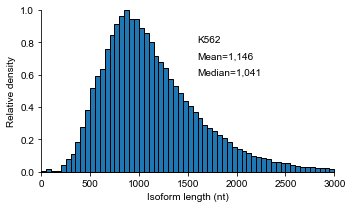

In [12]:
plt.figure(figsize=(5, 3))
ret = plt.hist(lengths, bins=60, range=(0, 3000), color="C0", edgecolor="black", clip_on=False)
vmax = max(ret[0])
plt.text(1600, vmax * 0.8, "K562")
plt.text(1600, vmax * 0.7, "Mean=%s" % format(int(np.mean(lengths)), ","))
plt.text(1600, vmax * 0.6, "Median=%s" % format(int(np.median(lengths)), ","))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Isoform length (nt)")
plt.ylabel("Relative density")
plt.xlim(0, 3000)
plt.ylim(0, vmax)
ys = np.arange(0, 1.1, 0.2)
plt.yticks([vmax * y for y in ys], ["%.1f" % y for y in ys])
plt.tight_layout()
plt.savefig("figures/isoform_lengths.pdf", dpi=300)

# Comparison with GENCODE transcripts

In [31]:
names = ['full-splice_match', 'incomplete-splice_match', 'novel_in_catalog', 'novel_not_in_catalog',
         'antisense', 'fusion', 'genic', 'intergenic']

rows = []
for cell in d["Cell"]:
    path = "../../1_NanoNASCseq/results/assembly/sqanti3/%s/%s/%s_classification.filtered_lite_classification.txt" % (cell.split(".")[0], cell, cell)
    if os.path.exists(path):
        tmp = pd.read_csv(path, sep="\t")
        counter = Counter(tmp["structural_category"])
        rows.append([counter[name] for name in names])
dat = pd.DataFrame(rows)
dat.columns = ["FSM", "ISM", "NIC", "NNC", "AntiSense", "Fusion", "Genic", "Intergenic"]

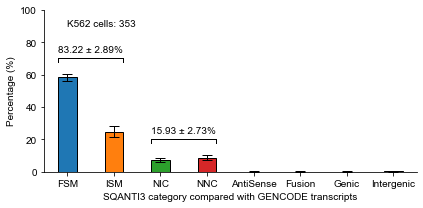

In [36]:
dat1 = dat[dat.sum(axis=1) > 2000]
dat2 = dat1.divide(dat1.sum(axis=1), axis=0) * 100
vs1 = dat2["FSM"] + dat2["ISM"]
vs2 = dat2["NIC"] + dat2["NNC"]

ys = dat2.mean(axis=0)
yerr = dat2.std(axis=0)
xs = np.arange(len(ys))

colors = ["C0", "C1", "C2", "C3", "C7", "C7", "C7", "C7"]
plt.figure(figsize=(6, 3))
# plt.title("SQANTI3 category compared with GENCODE transcripts")

plt.bar(xs, ys, yerr=yerr, width=0.4, color=colors, edgecolor="black", error_kw={"capsize": 5, "lw": 1})
plt.text(0, 90, "K562 cells: %d" % len(dat2))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)

x1, x2 = 0 - 0.2, 1 + 0.2
y = 70
plt.plot([x1, x2], [y, y], lw=1, color="black")
plt.plot([x1, x1], [y - 2, y], lw=1, color="black")
plt.plot([x2, x2], [y - 2, y], lw=1, color="black")
plt.text((x1 + x2) / 2, y + 4, "%.2f ± %.2f%%" % (np.mean(vs1), np.std(vs1)), ha="center")

x1, x2 = 2 - 0.2, 3 + 0.2
y = 20
plt.plot([x1, x2], [y, y], lw=1, color="black")
plt.plot([x1, x1], [y - 2, y], lw=1, color="black")
plt.plot([x2, x2], [y - 2, y], lw=1, color="black")
plt.text((x1 + x2) / 2, y + 4, "%.2f ± %.2f%%" % (np.mean(vs2), np.std(vs2)), ha="center")

plt.xticks(xs, dat2.columns, rotation=0)
plt.xlabel("SQANTI3 category compared with GENCODE transcripts")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/sqanti3_summary.pdf", dpi=300)

# Nucleotides content around polyA

In [13]:
regions = []
for run in runs:
    for cell in infos[infos["Run"] == run]["Cell"]:
        path = "../../1_NanoNASCseq/results/assembly/sqanti3/%s/%s/%s_classification.filtered_lite_classification.txt" % (cell.split(".")[0], cell, cell)
        if not os.path.exists(path):
            continue
        d = pd.read_csv(path, sep="\t")
        tids = d["isoform"]
        path = "../../1_NanoNASCseq/results/assembly/stringtie/%s/%s.gtf.gz" % (run, cell)
        with GtfFile(path) as f:
            records = [x for x in f]
        transcripts = {t.name: t for t in GtfTranscriptBuilder(records)}
        for tid in tids:
            t = transcripts[tid]
            if t.strand == "+":
                start = t.end - 50
            else:
                start = t.start - 50
            end = start + 100
            regions.append((t.chrom, start, end, t.strand))
    break
    
print(len(regions))
regions = set(regions)
print(len(regions))

282679
79159


In [14]:
m = np.zeros((5, 100))
bases = ["A", "C", "G", "T", "N"]
with FastaFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.fa") as fasta:
    for chrom, start, end, strand in regions:
        seq = fasta.fetch(chrom=chrom, start=start, end=end, strand=strand)
        for i, b in enumerate(seq):
            j = bases.index(b)
            m[j][i] += 1

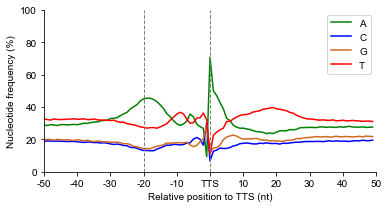

In [19]:
d = pd.DataFrame(m)
d.index = bases
d.columns = np.arange(-50, 50)
d = d / d.sum(axis=0) * 100

colors = ["green", "blue", "chocolate", "red"]
plt.figure(figsize=(5.5, 3))
for i, b in enumerate(bases[:4]):
    ys = d.loc[b]
    xs = d.columns
    plt.plot(xs, ys, label=b, color=colors[i])
plt.axvline(-20, ls="--", lw=1, color="grey")
plt.axvline(0, ls="--", lw=1, color="grey")
plt.xlim(-50, 50)
plt.ylim(0, 100)
if True:
    xs = np.arange(-50, 51, 10)
    ticks = [str(x) for x in xs]
    ticks[5] = "TTS"
    plt.xticks(xs, ticks)
plt.xlabel("Relative position to TTS (nt)")
plt.ylabel("Nucleotide frequency (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.tight_layout()
plt.savefig("figures/nucleotide_content_around_polya.pdf", dpi=300)